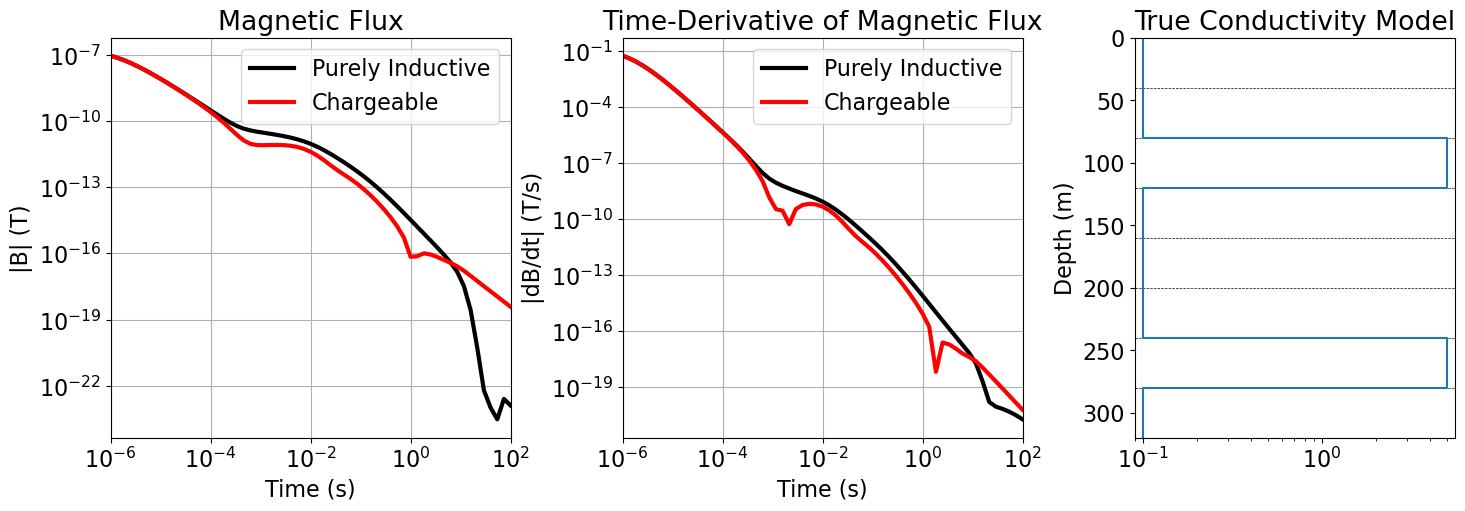

In [25]:
import numpy as np
from matplotlib import pyplot as plt

from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.utils import plot_1d_layer_model
source_location = np.array([0.0, 0.0, 0.5])
source_orientation = "z"
current_amplitude = 3.0
source_radius = 10.0

receiver_location = np.array([0.0, 0.0, 0.5])
receiver_orientation = "z"
times = np.logspace(-6, 2, 61)
receiver_list = [
    tdem.receivers.PointMagneticFluxDensity(receiver_location, times, orientation=receiver_orientation),
    tdem.receivers.PointMagneticFluxTimeDerivative(receiver_location, times, orientation=receiver_orientation)
]
waveform = tdem.sources.StepOffWaveform()
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=current_amplitude,
        radius=source_radius
    )
]
survey = tdem.Survey(source_list)
thicknesses = np.array([40.0, 40.0, 40, 40, 40, 40, 40])  # four layers
n_layer = len(thicknesses) + 1
sigma = 0.1
sigma_model = sigma * np.ones(n_layer)
sigma_model[2] = 5.0  
sigma_model[6] = 5.0
eta = 0.3  
tau = 0.01 
c = 0.75  
eta_model = eta * np.ones(n_layer)
tau_model = tau * np.ones(n_layer)
c_model = c * np.ones(n_layer)
model_mapping = maps.IdentityMap(nP=n_layer)
simulation_conductive = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping
)
dpred_conductive = simulation_conductive.dpred(sigma_model)
simulation_chargeable = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
    eta=eta,
    tau=tau,
    c=c
)
dpred_chargeable = simulation_chargeable.dpred(sigma_model)
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.25, 0.8])
ax1.loglog(times, np.abs(dpred_conductive[0:len(times)]), "k", lw=3)
ax1.loglog(times, np.abs(dpred_chargeable[0:len(times)]), "r", lw=3)
ax1.set_xlim([times.min(), times.max()])
ax1.grid()
ax1.legend(["Purely Inductive", "Chargeable"])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("|B| (T)")
ax1.set_title("Magnetic Flux")
ax2 = fig.add_axes([0.42, 0.1, 0.25, 0.8])
ax2.loglog(times, np.abs(dpred_conductive[len(times):]), "k", lw=3)
ax2.loglog(times, np.abs(dpred_chargeable[len(times):]), "r", lw=3)
ax2.set_xlim([times.min(), times.max()])
ax2.grid()
ax2.legend(["Purely Inductive", "Chargeable"])
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("|dB/dt| (T/s)")
ax2.set_title("Time-Derivative of Magnetic Flux")
ax3 = fig.add_axes([0.74, 0.1, 0.2, 0.8])
plot_1d_layer_model(thicknesses, sigma_model, ax=ax3, show_layers=True)
ax3.set_title("True Conductivity Model")

plt.show()
